In [1]:
import cmocean as cmo
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np
import time
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
import xarray as xr
from scipy import signal
from xmitgcm import open_mdsdataset

In [2]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')

There is a problem with Dask chunks, even if I'm explicitly saying chunks=None it just ignores me :-( and doing anything in the time axis takes a million years. Even trying to plot a simple time series. That is why I ended up doing the horrible piece of code below and saved the data.

In [3]:
sns.set_context('paper')

In [4]:
outdir = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL_SVB/01_SVB_febTS_output/'
outdir2 = '/data/SO2/sio-kramosmusalem/exp06_512x612x100_ORL/01_noSVB_febTS/'

levels = [0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 
          11, 12, 13, 14, 15, 16, 17,
          18, 19, 20, 21, 22, 23, 24, 25,
          26, 27, 28, 29, 30, 31,
          32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44,
          45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57,              
          58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 
          73, 78, 83, 88, 93, 98,]
iters = [xx for xx in range(10,1440*5+10,10)]
ds = open_mdsdataset(outdir, prefix=['eta','dynVars'], levels=levels, iters=iters, chunks=None)
ds2 = open_mdsdataset(outdir2, prefix=['eta','dynVars'], levels=levels, iters=iters, chunks=None)

In [5]:
depth_nob = ds2.Depth[:]
LAT = ds2['YC'][:]
LON = ds2['XC'][:]-360
lat = ds2.YC[:,0].data
lon = ds2.XC[0,:].data-360
Z = ds2['Z'][:]
Zl = ds2['Zl'][:]

# centers mask
hFacC = ds2['hFacC'][:]
hfac = np.ma.masked_values(hFacC, 0)
mask = np.ma.getmask(hfac)
dep_masked = np.ma.masked_values(depth_nob,0)
mask_dep = np.ma.getmask(dep_masked)
time = np.arange(0,720)*600

# centers mask bathy with bay
depth_bay = ds.Depth[:]
hFacCSVB = ds['hFacC'][:]
hfacSVB = np.ma.masked_values(hFacCSVB, 0)
maskSVB = np.ma.getmask(hfacSVB)

#
omega = 7.3E-5
N200 = 0.006919
N500 = 0.003614

#
z2 = 37 # Zl[37] = -197.2 m
z4 = 55 # Zl[55] = -508.2 m
dt = 10*60


Stations where we will investigate SVB-induced vertical velocity, w:

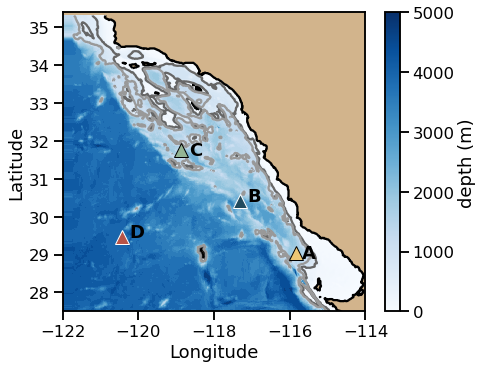

In [6]:
# Plot bay and approximate distances and reference circle
sns.set_context('talk')
fig, (ax1) = plt.subplots(1,1,figsize=(7,5.5), sharey=True)
ax1.set_facecolor('tan')
pc1 = ax1.pcolormesh(lon,lat, np.ma.masked_array(depth_bay,mask=maskSVB[0,:,:]), 
                     cmap='Blues', vmin=0, vmax=5000)
plt.colorbar(pc1, ax=ax1, label='depth (m)')
ax1.contour(lon,lat,depth_bay,levels=[0,500, 1000], 
            colors=['k','0.4','0.6'], 
            alphas=[1,0.2,0.2])                                                                           
ax1.set_xlabel('Longitude')
ax1.set_ylabel('Latitude')
ax1.set_aspect(1)
ax1.set_xlim([-122,-114])
ax1.set_ylim([27.5,35.4])

pta = [100,180]
ptb = [395,150]
ptc = [200,350]
ptd = [300,250]
colors = [ "#b75347", "#edc775", "#94b594", "#224b5e"]
ax1.plot(lon[pta[0]], lat[pta[1]], '^', color=colors[0],
         markeredgecolor='1', markersize=14)
ax1.plot(lon[ptb[0]], lat[ptb[1]], '^', color=colors[1],
         markeredgecolor='0', markersize=14)
ax1.plot(lon[ptc[0]], lat[ptc[1]], '^', color=colors[2],
         markeredgecolor='0', markersize=14)
ax1.plot(lon[ptd[0]], lat[ptd[1]], '^', color=colors[3],
         markeredgecolor='1', markersize=14)

ax1.text(lon[pta[0]]+0.2, lat[pta[1]], 'D', fontweight='bold', color='k')
ax1.text(lon[ptb[0]]+0.15, lat[ptb[1]]-0.15, 'A', fontweight='bold')
ax1.text(lon[ptc[0]]+0.2, lat[ptc[1]]-0.15, 'C', fontweight='bold')
ax1.text(lon[ptd[0]]+0.2, lat[ptd[1]], 'B', fontweight='bold')

plt.show()

In [7]:
times = np.arange(720)*600

In [8]:
var = np.load('../w_4stations.npz')

w max for station D is 2.141053e-06 m/s
w max for station A is 1.329059e-05 m/s
w max for station C is 2.326577e-06 m/s
w max for station B is 3.246963e-06 m/s


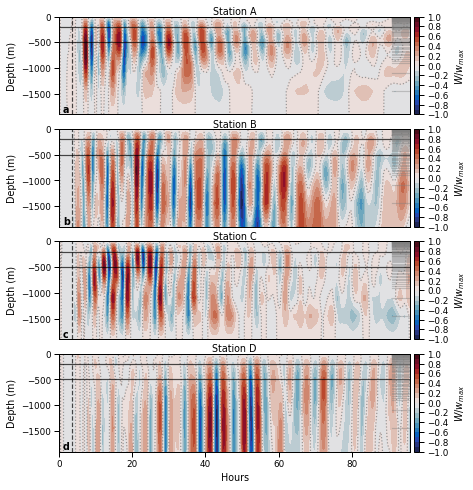

In [60]:
sns.set_context('paper')
fig = plt.figure(figsize=(7.48,8))
gs0 = gridspec.GridSpec(4,1,  wspace=0.1, hspace=0.15)
ax1 = plt.subplot(gs0[0])
ax2 = plt.subplot(gs0[1])
ax3 = plt.subplot(gs0[2])
ax4 = plt.subplot(gs0[3])

for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])

ax4.set_xlabel('Hours')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim(-1900,0)
    ax.set_xlim(0,96)

# -------- contourf w ---------------
for axx,st,pt,panel,stT in zip([ax4,ax1,ax3,ax2],['A','B','C','D'],[pta,ptb,ptc,ptd],['d','a','c','b'],['D','A','C','B']):
    varw = np.load('../wanom_tz_st%s.npz' %st)
    pc = axx.contourf(times/3600,Zl[:73],
                      np.transpose(varw["w_st%s" %st][:,:73]/np.max(abs(varw["w_st%s" %st][:,:73]))),
                      levels=np.linspace(-1,1,21),
                       cmap=cmo.cm.balance, 
                       vmin=-1, 
                       vmax=1)
    plt.colorbar(pc, ax=axx, label='$W/w_{max}$',pad=0.01, 
                 ticks=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1],
            )
    pc = axx.contour(times/3600,Zl[:73],
                     np.transpose(varw["w_st%s" %st][:,:73]/np.max(abs(varw["w_st%s" %st][:,:73]))),
                     levels=[0], alpha=0.8,
                     linestyles=[':'],
                     #colors=['yellow','green','purple','0.7','purple','green','yellow'],
                     colors=['0.5'])
    print('w max for station %s is %e m/s' %(stT,np.max(abs(varw["w_st%s" %st][:,:73]))))
    axx.set_title('Station %s' %stT, pad=0.01)
    axx.set_ylabel('Depth (m)')
    axx.axhline(-197, color='black', alpha=0.7)
    axx.axhline(-500, color='black', alpha=0.7)
    axx.axvline(3.5, color='black',linestyle='--', alpha=0.7)
    axx.text(0.01,0.02,panel, fontweight='bold',transform=axx.transAxes)
    for kk in Zl:
        axx.axhline(kk,xmin=0.95, xmax=1, color='0.5', alpha=0.4)
plt.savefig('figure9_w.png', dpi=500, bbox_inches='tight')
plt.show()

dh max for station D is 4.924183e-01 cm
dh max for station A is 7.512721e+00 cm
dh max for station C is 1.522538e+00 cm
dh max for station B is 4.317217e+00 cm


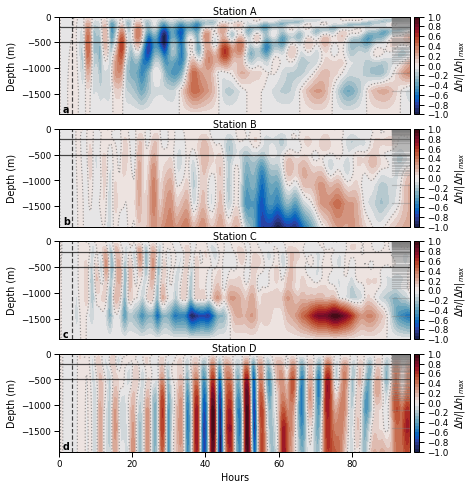

In [61]:
# plot vertical displacement instead of w

sns.set_context('paper')
fig = plt.figure(figsize=(7.48,8))
gs0 = gridspec.GridSpec(4,1,  wspace=0.1, hspace=0.15)
ax1 = plt.subplot(gs0[0])
ax2 = plt.subplot(gs0[1])
ax3 = plt.subplot(gs0[2])
ax4 = plt.subplot(gs0[3])

for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])

ax4.set_xlabel('Hours')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim(-1900,0)
    ax.set_xlim(0,96)

# -------- contourf w ---------------
for axx,st,pt,panel,stT in zip([ax4,ax1,ax3,ax2],['A','B','C','D'],[pta,ptb,ptc,ptd],['d','a','c','b'],['D','A','C','B']):
    varw = np.load('../wanom_tz_st%s.npz' %st)
    #disp = np.zeros_like(varw["w_st%s" %st][:,:73])
    disp[:,:] = 100*np.cumsum(varw["w_st%s" %st][:,:73]*dt,axis=0)
    
    pc = axx.contourf(times/3600,Zl[:73],
                      np.transpose(disp/np.max(abs(disp))),
                      levels=np.linspace(-1,1,31),
                      cmap=cmo.cm.balance,
                      vmin=-1, 
                      vmax=1)
    plt.colorbar(pc, ax=axx, label='$\Delta h/|\Delta h|_{max}$',pad=0.01, 
                 ticks=[-1,-0.8,-0.6,-0.4,-0.2,0,0.2,0.4,0.6,0.8,1])
    pc = axx.contour(times/3600,Zl[:73],
                     np.transpose(disp),
                     levels=[0], alpha=0.8,
                     linestyles=[':'],
                     #colors=['yellow','green','purple','0.7','purple','green','yellow'],
                     colors=['0.5'])
    print('dh max for station %s is %e cm' %(stT,np.max(abs(disp))))
    axx.set_title('Station %s' %stT, pad=0.01)
    axx.set_ylabel('Depth (m)')
    axx.axhline(-197, color='black', alpha=0.7)
    axx.axhline(-500, color='black', alpha=0.7)
    axx.axvline(3.5, color='black',linestyle='--', alpha=0.7)
    axx.text(0.01,0.02,panel, fontweight='bold',transform=axx.transAxes)
    for kk in Zl:
        axx.axhline(kk,xmin=0.95, xmax=1, color='0.5', alpha=0.4)
plt.savefig('figure9.png', dpi=500, bbox_inches='tight')
plt.show()

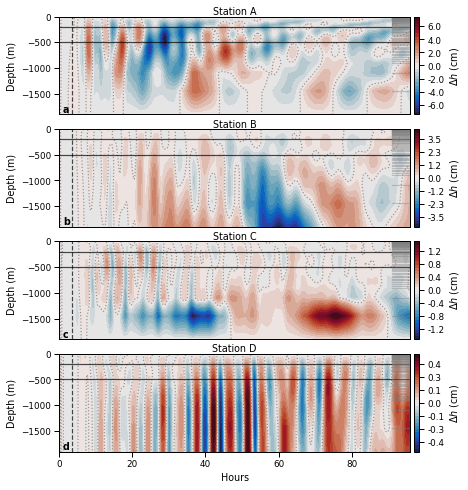

In [62]:
# plot vertical displacement instead of w

sns.set_context('paper')
fig = plt.figure(figsize=(7.48,8))
gs0 = gridspec.GridSpec(4,1,  wspace=0.1, hspace=0.15)
ax1 = plt.subplot(gs0[0])
ax2 = plt.subplot(gs0[1])
ax3 = plt.subplot(gs0[2])
ax4 = plt.subplot(gs0[3])

for ax in [ax1,ax2,ax3]:
    ax.set_xticks([])

ax4.set_xlabel('Hours')

for ax in [ax1,ax2,ax3,ax4]:
    ax.set_ylim(-1900,0)
    ax.set_xlim(0,96)

# -------- contourf w ---------------
for axx,st,pt,panel,stT in zip([ax4,ax1,ax3,ax2],['A','B','C','D'],[pta,ptb,ptc,ptd],['d','a','c','b'],['D','A','C','B']):
    varw = np.load('../wanom_tz_st%s.npz' %st)
    disp = np.zeros_like(varw["w_st%s" %st][:,:73])
    for tt in range(len(disp[:,0])):
        disp[tt,:] = 100*np.nansum(varw["w_st%s" %st][:tt,:73]*dt,axis=0)
    
    pc = axx.contourf(times/3600,Zl[:73],
                      np.transpose(disp),
                      levels=np.linspace(np.min(disp),-np.min(disp),31),
                      cmap=cmo.cm.balance,
                      vmin=np.min(disp), 
                      vmax=-np.min(disp))
    plt.colorbar(pc, ax=axx, label=r'$\Delta h$ (cm)',pad=0.01, format='%1.1f')
    pc = axx.contour(times/3600,Zl[:73],
                     np.transpose(disp),
                     levels=[0], alpha=0.8,
                     linestyles=[':'],
                     #colors=['yellow','green','purple','0.7','purple','green','yellow'],
                     colors=['0.5'])
    axx.set_title('Station %s' %stT, pad=0.01)
    axx.set_ylabel('Depth (m)')
    axx.axhline(-197, color='black', alpha=0.7)
    axx.axhline(-500, color='black', alpha=0.7)
    axx.axvline(3.5, color='black',linestyle='--', alpha=0.7)
    axx.text(0.01,0.02,panel, fontweight='bold',transform=axx.transAxes)
    for kk in Zl:
        axx.axhline(kk,xmin=0.95, xmax=1, color='0.5', alpha=0.4)
plt.savefig('figure9_wUnits.png', dpi=500, bbox_inches='tight')
plt.show()

0.987232
0.974759
1.056951
1.016141


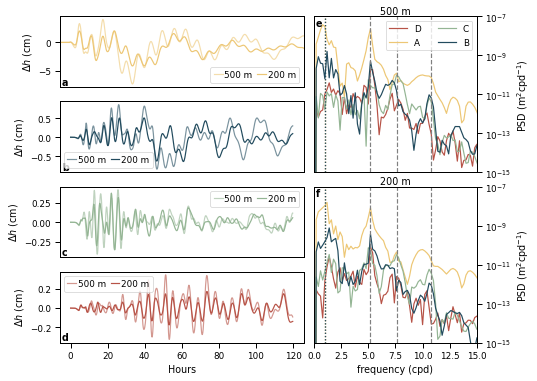

In [47]:
fig = plt.figure(figsize=(7.48,6))
gs0 = gridspec.GridSpec(1,2, width_ratios=[1.5,1], wspace=0.05, hspace=0.15)
gs01 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[1])
gs00 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[0])
ax1 = plt.subplot(gs01[0:2])
ax1b = plt.subplot(gs01[2:])
ax2 = plt.subplot(gs00[0])
ax3 = plt.subplot(gs00[1])
ax4 = plt.subplot(gs00[2])
ax5 = plt.subplot(gs00[3])
for ax in [ax2,ax3,ax4]:
    ax.set_xticks([])

ax5.set_xlabel('Hours')

#for ax in [ax3,ax4,ax5]:
#    ax.set_xlim(0,96)
#    ax.set_ylim(-.25,.25)
#    ax.axvline(3.5, color='0.5', linestyle='--')
#ax2.axvline(3.5, color='0.5', linestyle='--')
#ax2.set_ylim(-1.25,1.25)
ax2.set_xlim(0,96)
# ---- time series ----
disp0_500 = np.cumsum(var['w500'][0,:]*dt)
disp0_200 = np.cumsum(var['w200'][0,:]*dt)

ax5.plot(times[:]/3600, 100*disp0_500, label='500 m', 
        color=colors[0], alpha=0.6)
ax5.plot(times[:]/3600, 100*disp0_200, label='200 m', 
        color=colors[0], alpha=1)

disp1_500 = np.cumsum(var['w500'][1,:]*dt)
disp1_200 = np.cumsum(var['w200'][1,:]*dt)

ax2.plot(times[:]/3600, 100*disp1_500, label='500 m', 
        color=colors[1], alpha=0.6)
ax2.plot(times[:]/3600, 100*disp1_200, label='200 m', 
        color=colors[1], alpha=1)

disp2_500 = np.cumsum(var['w500'][2,:]*dt)
disp2_200 = np.cumsum(var['w200'][2,:]*dt)

ax4.plot(times[:]/3600, 100*disp2_500, label='500 m', 
        color=colors[2], alpha=0.6)
ax4.plot(times[:]/3600, 100*disp2_200, label='200 m', 
        color=colors[2], alpha=1)

disp3_500 = np.cumsum(var['w500'][3,:]*dt)
disp3_200 = np.cumsum(var['w200'][3,:]*dt)

ax3.plot(times[:]/3600, 100*disp3_500, label='500 m', 
        color=colors[3], alpha=0.6)
ax3.legend(ncol=2)
ax3.plot(times[:]/3600, 100*disp3_200, label='200 m', 
        color=colors[3], alpha=1)

for axx, lab in zip([ax2,ax3,ax4,ax5],['a','b','c','d']):
    axx.set_ylabel(r'$\Delta h$ (cm)')
    axx.legend(ncol=2, handletextpad=0.2, columnspacing=0.5,handlelength=1 )
    axx.text(0.01,0.03,lab, fontweight='bold',transform=axx.transAxes)


# ----- spectra -------
fs = 1/600 # 10 min data
st_names=['D','A','C','B']
disp500 = [disp0_500, disp1_500, disp2_500, disp3_500]
disp200 = [disp0_200, disp1_200, disp2_200, disp3_200]

for st, st_name, col, ind, disp500_st, disp200_st in zip(range(4), st_names, colors, 
                                                         [pta,ptb,ptc,ptd],disp500, disp200):
    
    fftFreq, signalPSD = signal.periodogram(disp500_st, fs)
    fftFreqb, signalPSDb = signal.periodogram(disp200_st,fs )

    ax1.plot(fftFreq*86400,signalPSD[:]/(1e4*86400),col,label=st_name)
    ax1b.plot(fftFreqb*86400,signalPSDb[:]/(1e4*86400),col,label=st_name)
      
    f = 86400*2*omega*np.sin(np.radians(lat[ind[1]]))/(2*np.pi) #cpd
    print('%f' %f)
    ax1.axvline(f, color=col, linestyle=':')
    ax1b.axvline(f, color=col, linestyle=':')
    
ax1.legend(ncol=2)
ax1.set_ylabel('PSD (m$^2$cpd$^{-1}$)')
ax1.set_xlim(0,15)
ax1.set_yscale('log')
ax1.set_ylim(1E-15, 1E-7)
ax1.set_title('500 m', pad=0)
ax1.set_xticks([])
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

ax1b.set_xlabel('frequency (cpd)')
ax1b.set_ylabel('PSD (m$^2$cpd$^{-1}$)')
ax1b.set_xlim(0,15)
ax1b.set_yscale('log')
ax1b.set_ylim(1E-15, 1E-7)
ax1b.set_title('200 m', pad=0)
ax1b.yaxis.tick_right()
ax1b.yaxis.set_label_position("right")

for axx, lab in zip([ax1, ax1b], ['e','f']):
    axx.axvline(5.2, color='0.5', linestyle='--')
    axx.axvline(7.6, color='0.5', linestyle='--')
    axx.axvline(10.8, color='0.5', linestyle='--')
    axx.text(0.01,0.94,lab, fontweight='bold',transform=axx.transAxes)
   
plt.tight_layout()
plt.savefig('figure10_wUnits.png', dpi=500, bbox_inches='tight')
plt.show()

0.987232
0.974759
1.056951
1.016141


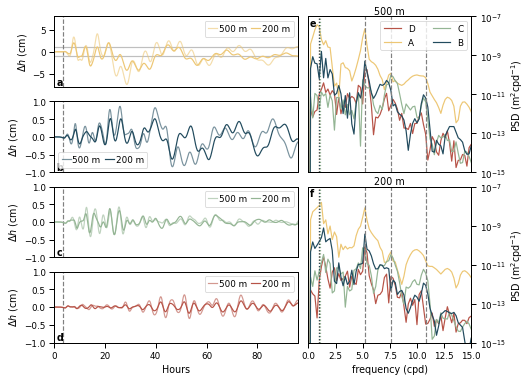

In [53]:
fig = plt.figure(figsize=(7.48,6))
gs0 = gridspec.GridSpec(1,2, width_ratios=[1.5,1], wspace=0.05, hspace=0.15)
gs01 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[1])
gs00 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[0])
ax1 = plt.subplot(gs01[0:2])
ax1b = plt.subplot(gs01[2:])
ax2 = plt.subplot(gs00[0])
ax3 = plt.subplot(gs00[1])
ax4 = plt.subplot(gs00[2])
ax5 = plt.subplot(gs00[3])
for ax in [ax2,ax3,ax4]:
    ax.set_xticks([])

ax5.set_xlabel('Hours')

for ax in [ax3,ax4,ax5]:
    ax.set_xlim(0,96)
    ax.set_ylim(-1,1)
    ax.axvline(3.5, color='0.5', linestyle='--')
ax2.axvline(3.5, color='0.5', linestyle='--')
ax2.set_ylim(-8,8)
ax2.set_xlim(0,96)
# ---- time series ----
disp0_500 = np.cumsum(var['w500'][0,:]*dt)
disp0_200 = np.cumsum(var['w200'][0,:]*dt)

ax5.plot(times[:]/3600, 100*disp0_500, label='500 m', 
        color=colors[0], alpha=0.6)
ax5.plot(times[:]/3600, 100*disp0_200, label='200 m', 
        color=colors[0], alpha=1)

ax2.axhline(1,color='0.5', alpha=0.5)
ax2.axhline(-1,color='0.5', alpha=0.5)
disp1_500 = np.cumsum(var['w500'][1,:]*dt)
disp1_200 = np.cumsum(var['w200'][1,:]*dt)

ax2.plot(times[:]/3600, 100*disp1_500, label='500 m', 
        color=colors[1], alpha=0.6)
ax2.plot(times[:]/3600, 100*disp1_200, label='200 m', 
        color=colors[1], alpha=1)

disp2_500 = np.cumsum(var['w500'][2,:]*dt)
disp2_200 = np.cumsum(var['w200'][2,:]*dt)

ax4.plot(times[:]/3600, 100*disp2_500, label='500 m', 
        color=colors[2], alpha=0.6)
ax4.plot(times[:]/3600, 100*disp2_200, label='200 m', 
        color=colors[2], alpha=1)

disp3_500 = np.cumsum(var['w500'][3,:]*dt)
disp3_200 = np.cumsum(var['w200'][3,:]*dt)

ax3.plot(times[:]/3600, 100*disp3_500, label='500 m', 
        color=colors[3], alpha=0.6)
ax3.legend(ncol=2)
ax3.plot(times[:]/3600, 100*disp3_200, label='200 m', 
        color=colors[3], alpha=1)

for axx, lab in zip([ax2,ax3,ax4,ax5],['a','b','c','d']):
    axx.set_ylabel(r'$\Delta h$ (cm)')
    axx.legend(ncol=2, handletextpad=0.2, columnspacing=0.5,handlelength=1 )
    axx.text(0.01,0.03,lab, fontweight='bold',transform=axx.transAxes)


# ----- spectra -------
fs = 1/600 # 10 min data
st_names=['D','A','C','B']
disp500 = [disp0_500, disp1_500, disp2_500, disp3_500]
disp200 = [disp0_200, disp1_200, disp2_200, disp3_200]

for st, st_name, col, ind, disp500_st, disp200_st in zip(range(4), st_names, colors, 
                                                         [pta,ptb,ptc,ptd],disp500, disp200):
    
    fftFreq, signalPSD = signal.periodogram(disp500_st, fs)
    fftFreqb, signalPSDb = signal.periodogram(disp200_st,fs )

    ax1.plot(fftFreq*86400,signalPSD[:]/(1e4*86400),col,label=st_name)
    ax1b.plot(fftFreqb*86400,signalPSDb[:]/(1e4*86400),col,label=st_name)
      
    f = 86400*2*omega*np.sin(np.radians(lat[ind[1]]))/(2*np.pi) #cpd
    print('%f' %f)
    ax1.axvline(f, color=col, linestyle=':')
    ax1b.axvline(f, color=col, linestyle=':')
    
ax1.legend(ncol=2)
ax1.set_ylabel('PSD (m$^2$cpd$^{-1}$)')
ax1.set_xlim(0,15)
ax1.set_yscale('log')
ax1.set_ylim(1E-15, 1E-7)
ax1.set_title('500 m', pad=0)
ax1.set_xticks([])
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

ax1b.set_xlabel('frequency (cpd)')
ax1b.set_ylabel('PSD (m$^2$cpd$^{-1}$)')
ax1b.set_xlim(0,15)
ax1b.set_yscale('log')
ax1b.set_ylim(1E-15, 1E-7)
ax1b.set_title('200 m', pad=0)
ax1b.yaxis.tick_right()
ax1b.yaxis.set_label_position("right")

for axx, lab in zip([ax1, ax1b], ['e','f']):
    axx.axvline(5.2, color='0.5', linestyle='--')
    axx.axvline(7.6, color='0.5', linestyle='--')
    axx.axvline(10.8, color='0.5', linestyle='--')
    axx.text(0.01,0.94,lab, fontweight='bold',transform=axx.transAxes)
   
plt.tight_layout()
plt.savefig('figure10.png', dpi=500, bbox_inches='tight')
plt.show()

0.987232
0.974759
1.056951
1.016141


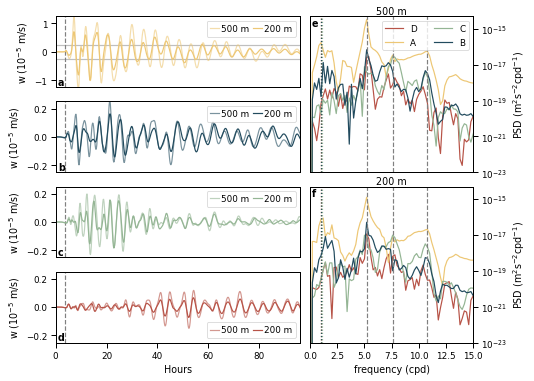

In [20]:
fig = plt.figure(figsize=(7.48,6))
gs0 = gridspec.GridSpec(1,2, width_ratios=[1.5,1], wspace=0.05, hspace=0.15)
gs01 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[1])
gs00 = gridspec.GridSpecFromSubplotSpec(4, 1, subplot_spec=gs0[0])
ax1 = plt.subplot(gs01[0:2])
ax1b = plt.subplot(gs01[2:])
ax2 = plt.subplot(gs00[0])
ax3 = plt.subplot(gs00[1])
ax4 = plt.subplot(gs00[2])
ax5 = plt.subplot(gs00[3])
for ax in [ax2,ax3,ax4]:
    ax.set_xticks([])

ax5.set_xlabel('Hours')

for ax in [ax3,ax4,ax5]:
    ax.set_xlim(0,96)
    ax.set_ylim(-.25,.25)
    ax.axvline(3.5, color='0.5', linestyle='--')
ax2.axvline(3.5, color='0.5', linestyle='--')
ax2.set_ylim(-1.25,1.25)
ax2.set_xlim(0,96)
# ---- time series ----
ax5.plot(times[:]/3600, var['w500'][0,:]*1E5, label='500 m', 
        color=colors[0], alpha=0.6)
ax5.plot(times[:]/3600, var['w200'][0,:]*1E5, label='200 m', 
        color=colors[0], alpha=1)

ax2.axhline(0.25,color='0.5', alpha=0.5)
ax2.axhline(-0.25,color='0.5', alpha=0.5)
ax2.plot(times[:]/3600, var['w500'][1,:]*1E5, label='500 m', 
        color=colors[1], alpha=0.6)
ax2.plot(times[:]/3600, var['w200'][1,:]*1E5, label='200 m', 
        color=colors[1], alpha=1)

ax4.plot(times[:]/3600, var['w500'][2,:]*1E5, label='500 m', 
        color=colors[2], alpha=0.6)
ax4.plot(times[:]/3600, var['w200'][2,:]*1E5, label='200 m', 
        color=colors[2], alpha=1)

ax3.plot(times[:]/3600, var['w500'][3,:]*1E5, label='500 m', 
        color=colors[3], alpha=0.6)
ax3.legend(ncol=2)
ax3.plot(times[:]/3600, var['w200'][3,:]*1E5, label='200 m', 
        color=colors[3], alpha=1)

for axx, lab in zip([ax2,ax3,ax4,ax5],['a','b','c','d']):
    axx.set_ylabel('w ($10^{-5}$ m/s)')
    axx.legend(ncol=2, handletextpad=0.2, columnspacing=0.5,handlelength=1 )
    axx.text(0.01,0.03,lab, fontweight='bold',transform=axx.transAxes)
   
# ----- spectra -------
fs = 1/600 # 10 min data
st_names=['D','A','C','B']
for st, st_name, col, ind in zip(range(4), st_names, colors, [pta,ptb,ptc,ptd]):
    
    fftFreq, signalPSD = signal.periodogram(var['w500'][st,:], fs)
    fftFreqb, signalPSDb = signal.periodogram(var['w200'][st,:],fs )

    ax1.plot(fftFreq*86400,signalPSD[:]/(1e4*86400),col,label=st_name)
    ax1b.plot(fftFreqb*86400,signalPSDb[:]/(1e4*86400),col,label=st_name)
      
    f = 86400*2*omega*np.sin(np.radians(lat[ind[1]]))/(2*np.pi) #cpd
    print('%f' %f)
    ax1.axvline(f, color=col, linestyle=':')
    ax1b.axvline(f, color=col, linestyle=':')
    
ax1.legend(ncol=2)
ax1.set_ylabel('PSD (m$^2$s$^{-2}$cpd$^{-1}$)')
ax1.set_xlim(0,15)
ax1.set_yscale('log')
ax1.set_ylim(1E-23, 5E-15)
ax1.set_title('500 m', pad=0)
ax1.set_xticks([])
ax1.yaxis.tick_right()
ax1.yaxis.set_label_position("right")

ax1b.set_xlabel('frequency (cpd)')
ax1b.set_ylabel('PSD (m$^2$s$^{-2}$cpd$^{-1}$)')
ax1b.set_xlim(0,15)
ax1b.set_yscale('log')
ax1b.set_ylim(1E-23, 5E-15)
ax1b.set_title('200 m', pad=0)
ax1b.yaxis.tick_right()
ax1b.yaxis.set_label_position("right")

for axx, lab in zip([ax1, ax1b], ['e','f']):
    axx.axvline(5.2, color='0.5', linestyle='--')
    axx.axvline(7.6, color='0.5', linestyle='--')
    axx.axvline(10.8, color='0.5', linestyle='--')
    axx.text(0.01,0.94,lab, fontweight='bold',transform=axx.transAxes)
   
plt.tight_layout()
plt.savefig('figure10_w.png', dpi=500, bbox_inches='tight')
plt.show()

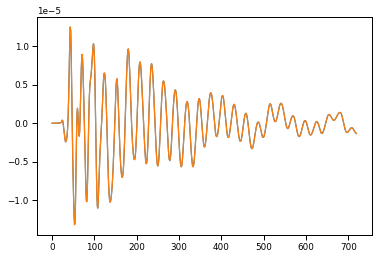

In [39]:
varw = np.load('../wanom_tz_stB.npz')
st = 'B'
plt.plot(varw["w_st%s" %st][:,55])
plt.plot(var['w500'][1,:])

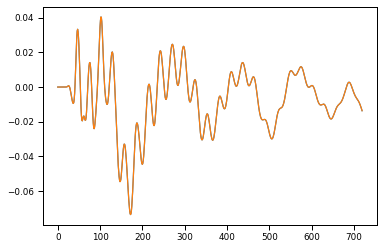

In [41]:
varw = np.load('../wanom_tz_stB.npz')
st = 'B'
plt.plot(np.cumsum(varw["w_st%s" %st][:,55]*dt))
plt.plot(np.cumsum(var['w500'][1,:]*dt))

In [58]:
print('%1.1f' %Z[72])

-1973.2
